## Import Libraries

In [10]:
# Package imports
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
import seaborn as sns
import itertools

# Display plots inline and change default figure size
%matplotlib inline

First we will try to classify a fully linearly seperable dataset using a logistic regression implemented from scratch using neural net mindset (forward and backpropagation)

In [76]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Use pandas to read the CSV file as a dataframe
df = pd.read_csv("drive/My Drive/datasets/blobs250.csv")

In [18]:
df.head(5)

,X0,X1,X2,Class
0,0.961400,5.677191,11.407020,0
1,2.372228,5.335292,9.460564,0
2,2.022249,7.501127,9.072816,0
3,4.464773,7.819388,9.183951,0
4,1.191087,5.880269,10.119531,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X0      250 non-null    float64
 1   X1      250 non-null    float64
 2   X2      250 non-null    float64
 3   Class   250 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 7.9 KB


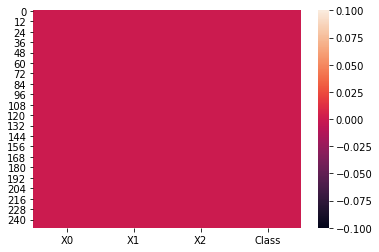

In [20]:
sns.heatmap(df.isnull())
plt.show()

In [21]:
# The y values are those labelled 'Class': extract their values
y = df['Class'].values

# The x values are all other columns
X = df.values     # convert the remaining columns to a numpy array

In [22]:
# Some examples of working with the data, to look at rows/columns
print ("len(X):", len(X))            # outer array: one per sample
print ("len(X[0]):", len(X[0]))      # each inner array is the attributes of one sample
print ("len(X[:,0]):", len(X[:,0]))  # select column 0 from array

# np.shape returns all dimensions of the array
(nsamples, nattribs) = np.shape(X)
print ("X: nsamples =", nsamples, ", nattribs =", nattribs)

# Now example the y vector (1D array)
print ("len(y)", len(y))
print ("np.shape(y):", np.shape(y))

# You can transpose the y data using 'reshape'
yt = np.reshape(y, (len(y),1))  
print ("np.shape(yt):", np.shape(yt))
(nsamples, nattribs) = np.shape(yt)
print ("y transpose: nsamples =", nsamples, ", nattribs =", nattribs)

len(X): 250
len(X[0]): 4
len(X[:,0]): 250
X: nsamples = 250 , nattribs = 4
len(y) 250
np.shape(y): (250,)
np.shape(yt): (250, 1)
y transpose: nsamples = 250 , nattribs = 1


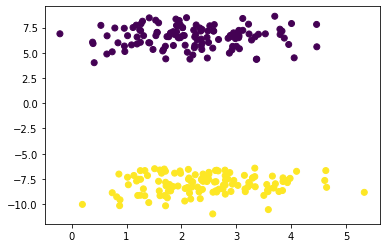

In [23]:
# plot X[0] vs X[1] and colour points according to the class, y
plt.scatter(X[:,0], X[:,1], c=y)  

## Splitting dataset in train/test

In [24]:
# extract the features and target variable
features = df.drop(columns="Class")
target = df["Class"]
x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.20)

# Data Scaling

the min_max_scaler is a function which takes the data column by column and scale the data on the bases of minimum and maximum value of the column and makes the data scale so that it can be used for better prediction. $$ x\_scaled(x) =  \frac{x-min(x)}{max(x)–min(x)} $$ The given formula is used to scale the data. The range used id {0,1}

ref for scaler: https://towardsdatascience.com/preprocessing-with-sklearn-a-complete-and-comprehensive-guide-670cb98fcfb9

In [25]:
def min_max_scaler(data):
    # describe_dataframe contains the statistical data of the data frame like min, max, std..... for all columns
    describe_dataframe=data.describe()
    # the minimum and the maximum values array is extracted from the describe_dataframe so that it can be used to scale the data
    min_array=list(describe_dataframe.iloc[3]) # the third row is minumum array for all column in describe
    max_array=list(describe_dataframe.iloc[7]) # the seventh row is maximum array for all column in describe
    for row in range(data.shape[0]):
        for col in range(data.shape[1]):
            # x_scaled = (x-min(x)) / (max(x)–min(x)) ....... this is the formula coded below  
            data.iloc[row][col]=(data.iloc[row][col]-min_array[col])/(max_array[col]-min_array[col]) # min max scaler
    return data

In [26]:
scaled_training_data=min_max_scaler(x_train).values
scaled_test_data = min_max_scaler(x_test).values

## Model Training and Prediction (self)
In linear regration we predict continues value. But unlikely in logistic we have to deatl with the binary values like {0,1}. we have to give answer like the given value will belong to which cluster of class. We get range of probability on which bases we create a threashold and select the classification.

the below is the sigmoidal funciton which creates a curve for binary classification: $$ g(z) =  \frac{1}{1+e^{-z}} $$

In [27]:
def sigmoid(z):
    sig_z=1 / (1 + np.exp(-z))
    return sig_z

In simple words if it is said cost is the amount of efforts to reach the minima so that the prediction can be done. it gives the distance of predicted value from the orginal. 
Here we do not do sum as we are calcualting on single value

$$ Cost ={y^{(i)} log(y^{(i)}) + (1-y^{(i)})log((1-y^{(i)})})$$

In [28]:
def cost(y_hat,y):
    c = y*np.log(y_hat)+(1-y)*np.log(1-y_hat)
    # c= -(1/len(y)) * np.sum(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))
    return c

# Learning weights and bias

In [29]:
# here we take the y_hat, y  and x and than we try to get the weights
def get_weight(y_hat,y,x):
    # we subtract out y_hat with the value of y then we multiply to get the delta wights
    del_wig = (y_hat-y)*x
    ##return the value of delta wight
    return del_wig

In [30]:
def get_bias(y_hat,y):
    ## here we subtract our y_hat with the value of y to get the delta bias
    del_bias = y_hat-y
    ## return delta bias
    return del_bias

In [38]:
def modal_part_one(x,y,max_iter,alpha,threshold=10**-6):

    ## take a random wight at the start, it can be any wight because through the iteration we will be going to update it 
    weight=np.random.normal(0,0.01,x.shape[1])
    ## it is the bias it will also any number but we take a uniform array of biases throught out, we will be adding out bias to weights
    bias=np.random.uniform(0,1)
    costList = []
    itrList = []

    ## we will loop till the value of maximum teration or if the convergence comes before max iteration we break the loop
    while(max_iter!=0):
        index = np.random.randint(x.shape[0])
        x_index = x[index]
        y_index = y.values[index]

        ## we valculate the value of y_hat and with the value of y_hat we find out cost
        y_hat=sigmoid(np.dot(weight,x_index)+bias)
        ## cost is calculated on the bases of the y_hat
        cost_old=cost(y_hat,y_index)
        if max_iter%100 == 0:
            costList.append(cost_old)
            itrList.append(max_iter)
        #print(cost_old)

        ## we update out wights 
        weight=weight-alpha*get_weight(y_hat,y_index,x_index)
        ## update bias
        bias=bias-alpha*get_bias(y_hat,y_index)

        ## now with the updated bias and wights we calcualte our new cost
        ## then new cost is more relevent as we have upadated our weights
        y_hat=sigmoid(np.dot(weight,x_index)+bias)
        cost_new=cost(y_hat,y_index)

        ## we take the absolute value and break the loop then the cost difference is less then the threshold. 
        ## more low the threshold more accurate the values are
        if abs(cost_old-cost_new) < threshold:
            break
        
        ## we dicrease the iteration to reach end of the loop
        max_iter = max_iter - 1

    return {"weight":weight,"bias":bias,"costList":costList,"itrList":itrList,"alpha":alpha,"threshold":threshold}

In [66]:
## here we set the cut off threshold and with the wight and bias we calculate our target value
def predict(x,w,b):
    y_return = []
    cut_off = 0.5
    y_predict = np.dot(x,w)+b
    for y in y_predict:
        if y>cut_off:
            y_return.append(1)
        else:
            y_return.append(0)
    return y_return

In [40]:
## here actual and predicted y values are compared and we find the accuracy
def accuracy(predict_y,actual_y):
    y_count = 0
    for i in range(len(actual_y)):
        if predict_y[i] == actual_y.values[i]:
            y_count = y_count+1
    return y_count/len(actual_y)

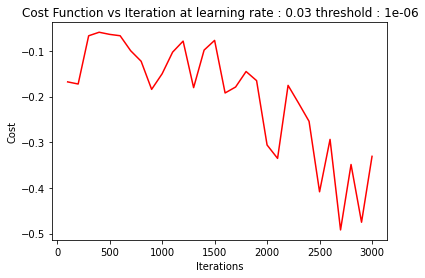

In [41]:
output = modal_part_one(x_train.values,y_train,max_iter=3000,alpha=0.03)
w,b,costList,itrList,alpha,threshold = output["weight"],output["bias"],output["costList"],output["itrList"],output["alpha"],output["threshold"]

plt.plot(itrList,costList,'red')
plt.title("Cost Function vs Iteration at learning rate : "+str(alpha)+" threshold : "+str(threshold))
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()


In [42]:
y_pred = predict(scaled_test_data,w,b)

In [43]:
print('accuracy:',accuracy(y_pred,y_test))

accuracy: 1.0


## Repeating the process on non linearly seperable dataset

In [60]:
# Use pandas to read the CSV file as a dataframe
df = pd.read_csv("drive/My Drive/datasets/moons400.csv")
df.head(5)

,X0,X1,Class
0,2.071069,0.411529,1
1,-0.335398,1.032266,0
2,1.256631,-0.363937,1
3,1.269361,-0.379086,1
4,-0.839940,0.203669,0


len(X): 400
len(X[0]): 3
len(X[:,0]): 400
X: nsamples = 400 , nattribs = 3
len(y) 400
np.shape(y): (400,)
np.shape(yt): (400, 1)
y transpose: nsamples = 400 , nattribs = 1


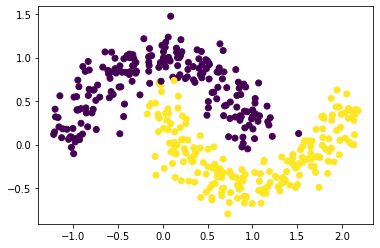

In [61]:
# The y values are those labelled 'Class': extract their values
y = df['Class'].values

# The x values are all other columns
X = df.values     # convert the remaining columns to a numpy array

# Some examples of working with the data, to look at rows/columns
print ("len(X):", len(X))            # outer array: one per sample
print ("len(X[0]):", len(X[0]))      # each inner array is the attributes of one sample
print ("len(X[:,0]):", len(X[:,0]))  # select column 0 from array

# np.shape returns all dimensions of the array
(nsamples, nattribs) = np.shape(X)
print ("X: nsamples =", nsamples, ", nattribs =", nattribs)

# Now example the y vector (1D array)
print ("len(y)", len(y))
print ("np.shape(y):", np.shape(y))

# You can transpose the y data using 'reshape'
yt = np.reshape(y, (len(y),1))  
print ("np.shape(yt):", np.shape(yt))
(nsamples, nattribs) = np.shape(yt)
print ("y transpose: nsamples =", nsamples, ", nattribs =", nattribs)

# plot X[0] vs X[1] and colour points according to the class, y
plt.scatter(X[:,0], X[:,1], c=y)  

In [62]:
# extract the features and target variable
features = df.drop(columns="Class")
target = df["Class"]
x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.20)

In [63]:
scaled_training_data=min_max_scaler(x_train).values
scaled_test_data = min_max_scaler(x_test).values

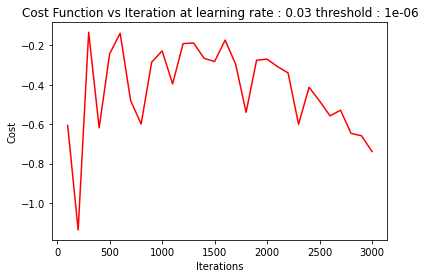

In [64]:
output = modal_part_one(x_train.values,y_train,max_iter=3000,alpha=0.03)
w,b,costList,itrList,alpha,threshold = output["weight"],output["bias"],output["costList"],output["itrList"],output["alpha"],output["threshold"]

plt.plot(itrList,costList,'red')
plt.title("Cost Function vs Iteration at learning rate : "+str(alpha)+" threshold : "+str(threshold))
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

In [67]:
y_pred = predict(scaled_test_data,w,b)

In [68]:
print('accuracy:',accuracy(y_pred,y_test))

accuracy: 0.8


# Shallow Neural Networks

Activation Function Hyperbolic tangent: $$ tanh(z) = \frac {e^{z}-e^{-z}}{e^{z}+e^{-z}} $$

ref:
1. http://ufldl.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks/

In [69]:
def hyperbolic_tangent_activation(z):
    tanh = (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
    return tanh

logistic : $$ f'(z) = f(z)(1-f(z)) $$

In [70]:
def logistic_activation(z):
## we use the same sigmoid function created above
    l_a = hyperbolic_tangent_activation(z).dot((1-hyperbolic_tangent_activation(z)).T)
    return l_a

ref: http://ufldl.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks/ 

1: Set ΔW(l):=0, Δb(l):=0 (matrix/vector of zeros) for all l.

2: For i=1 to m, 

$\quad$   1. Use backpropagation to compute $ ∇W(l)J(W,b;x,y) and ∇b(l)J(W,b;x,y)$. 

$\quad$   2. Set $ ΔW(l):=ΔW(l)+∇W(l)J(W,b;x,y) $. 

$\quad$   3. Set $ Δb(l):=Δb(l)+∇b(l)J(W,b;x,y) $. 

3.Update the parameters:
$$ W^{(l)}=W^{(l)}−α \left[ \left( \frac{1}{m}ΔW^{(l)} \right) +λW^{(l)} \right] $$ 

$$ b^{(l)}=b^{(l)}−α \left[ \frac{1}{m}Δb^{(l)} \right] $$

In [71]:
def modal_part_two(x,y,hidden_layer=2,output_layer=1,max_itr=10000,alpha=0.03,threshold=10**-6):
    ## input layer - it the list of all the features on which we want to calculate the weight, bias and target value
    input_layer=x.shape[1]
    
    ## we start with the assignmanet of the random wights at the start
    ## we take the initial weights for layer one
    layer_one_weights=np.random.normal(0,0.01,(input_layer,hidden_layer))
    ## we take the initial weights for layer two
    layer_two_weights=np.random.normal(0,0.01,(hidden_layer,output_layer))
    
    ## we take the initial bias for layer one
    layer_one_bias=np.random.uniform(0,1,hidden_layer).reshape(1,hidden_layer)
    ## we take the initial bias for layer one
    layer_two_bias=np.random.uniform(0,1,output_layer).reshape(1,output_layer)
    
    ## start with the inital cost = zero
    cost_old = 0
    while (max_itr!=0):
        
        ## forward propogation
        index = np.random.randint(x.shape[0])
        ## the index should match and the index of the updated bias and weight 
        ## we are giving shape to the array without changing the data
        x_index=x[index].reshape(x.shape[1],1)
        y_index=y[index]
        
        ## sum of weighted inputs to ith node and lth layer(here the lth layer is first)
        z_1=np.dot(x_index.T,layer_one_weights) + layer_one_bias
        ## activation of the ith layer (here the ith layer it the first)
        a_1 = sigmoid(z_1)
        
        ## sum of weighted inputs to ith node and lth layer(here the lth layer is second)
        z_2 = np.dot(a_1,layer_two_weights) + layer_two_bias
        ## activation of the ith node (here the ith node it the second)
        a_2 = sigmoid(z_2)
        
        ## we get the new cost by the value of the activation function of the second node and y_index
        cost_new=cost(a_2,y_index)
        
        ## id the absolute value of the cost function is less then the threshold then we break the loop
        if abs(cost_old-cost_new)<threshold:
            break

        ## we update the old cost with the new
        cost_old = cost_new
        
        ## back propogation
        
        ## we update our delta
        delta_z2 = a_2-y_index
        ## we update the layer two weights
        delta_layer_two_weights = delta_z2*a_1
        delta_layer_two_bias = delta_z2
        
        ## call the activation function to get the delta values
        delta_z1 = np.matrix(logistic_activation(z_1)*(np.dot(delta_z2,layer_two_weights.T)))
        ## update the delta weights
        delta_layer_one_weights = np.dot(delta_z1.T,x_index.T)
        ## update the delta bias 
        delta_layer_one_bias = delta_z1
        
        ## new weights are updation for the layers
        layer_one_weights = layer_one_weights - alpha*np.matrix(delta_layer_one_weights).T
        ## layer one new bias calculation
        layer_one_bias = layer_one_bias - alpha*delta_layer_one_bias
        ## new layer two weights
        layer_two_weights = layer_two_weights - alpha*np.matrix(delta_layer_two_weights).T
        ## new layer two bias
        layer_two_bias = layer_two_bias - alpha*delta_layer_two_bias
        
        ## reduce iteraion as we want to end the while loop
        max_itr = max_itr - 1
    ## we now return the weights and bias to calculate the prediction of the target value
    return layer_one_weights,layer_two_weights,layer_one_bias,layer_two_bias

In [72]:
## here we take the x features, weights and biases to predict the values of target
def predict(x,w_1,w_2,b_1,b_2):
    
    ## first we get the hidden values layer one
    z_1 = np.dot(x,w_1) + b_1
    a_1 = sigmoid(z_1)
    
    ## second we get the hidden values layer two
    z_2 = np.dot(a_1,w_2) + b_2
    a_2 = sigmoid(z_2)
    y_return=[]
    cut_off=0.5
    ## we remove single-dimensional entries from the shape array
    y_predict = a_2 
    ## update values of i as per the threshold cutoff
    for y in np.squeeze(np.asarray(y_predict)):
        if y>cut_off:
            y_return.append(1)
        else:
            y_return.append(0)
            
    return y_return

In [73]:
w_1,w_2,b_1,b_2 = modal_part_two(scaled_training_data,y_train.values,2)

In [74]:
y_pred = predict(scaled_test_data,w_1,w_2,b_1,b_2)

In [75]:
accuracy(y_pred,y_test)

0.85

We can observe that the accuracy has been increased from .08 to .85 due to addition of one extra hidden layer

# Neural net classification on CIFAR Dataset

Note that the CIFAR-10 images as displayed are quite fuzzy looking, because they are low res (32x32).

Befor running this:

Download the CIFAR-10 dataset from https://www.cs.toronto.edu/~kriz/cifar.html
Unzip and extract the tar file to get individual files called data_batch_1, etc.

References:  https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c

Description of the steps followed to solve the part 
  1. Read the batch data 
  2. Extract the image byte data from the batch 
  3. Read the labels from the batch data 
  4. Take out the indexes of all the labels which are required to predict 
  5. With the help of the indexes filter the bite data of the image  
  6. now once we got the image data and the labels; we are now required to define feature and target  
  7. Features = the filtered image data as per the index 
  8. Target = convert the extracted labels as per the indexes to 0 and 1. As it will be a binary classification 
  9. now we got our Features and Target we are ready to train our model; so train it 
  10. predict the values as per the cut-off value 
  11. predict the accuracy as per the given test data

In [77]:
# This function taken from the CIFAR website
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Loaded in this way, each of the batch files contains a dictionary with the following elements:
#   data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. 
#           The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. 
#           The image is stored in row-major order, so that the first 32 entries of the array are the red channel values 
#           of the first row of the image.
#   labels -- a list of 10000 numbers in the range 0-9. 
#             The number at index i indicates the label of the ith image in the array data.

In [81]:
def loadbatch(batchname):
    folder = r'drive/My Drive/datasets/cifar-10-batches-py'
    batch = unpickle(folder+"/"+batchname)
    return batch

In [82]:
def loadlabelnames():
    folder = r'drive/My Drive/datasets/cifar-10-batches-py'
    meta = unpickle(folder+"/"+'batches.meta')
    return meta[b'label_names']

In [83]:
def visualise(data, index):
    # MM Jan 2019: Given a CIFAR data nparray and the index of an image, display the image.
    # Note that the images will be quite fuzzy looking, because they are low res (32x32).

    picture = data[index]
    # Initially, the data is a 1D array of 3072 pixels; reshape it to a 3D array of 3x32x32 pixels
    # Note: after reshaping like this, you could select one colour channel or average them.
    picture.shape = (3,32,32) 
    
    # Plot.imshow requires the RGB to be the third dimension, not the first, so need to rearrange
    picture = picture.transpose([1, 2, 0])
    plt.imshow(picture)
    plt.show()

In [85]:
batch5 = loadbatch('data_batch_5')
print("Number of items in the batch is", len(batch5))

# Display all keys, so we can see the ones we want
print('All keys in the batch:', batch5.keys())

Number of items in the batch is 4
All keys in the batch: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [86]:
data = batch5[b'data']
labels = batch5[b'labels']
print('size of data in batch:',len(data),", size of labels:",len(labels))
print(type(data))
print(data.shape)

names = loadlabelnames()

size of data in batch: 10000 , size of labels: 10000
<class 'numpy.ndarray'>
(10000, 3072)


## Visualize the data

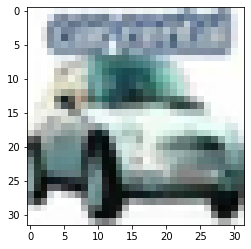

Image 0 : Class is  b'automobile'


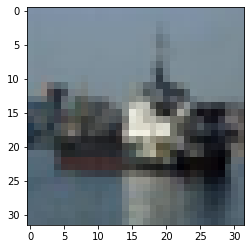

Image 1 : Class is  b'ship'


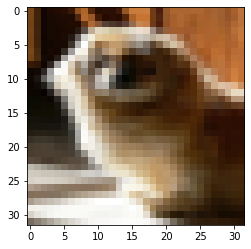

Image 2 : Class is  b'dog'


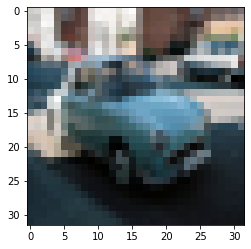

Image 3 : Class is  b'automobile'


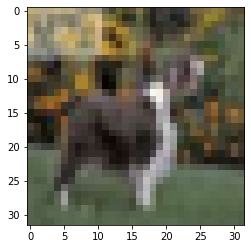

Image 4 : Class is  b'dog'


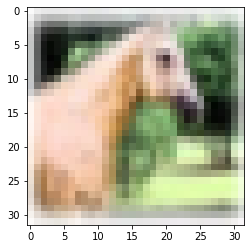

Image 5 : Class is  b'horse'


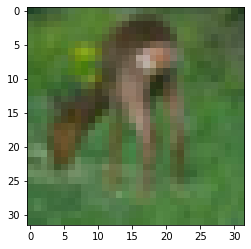

Image 6 : Class is  b'deer'


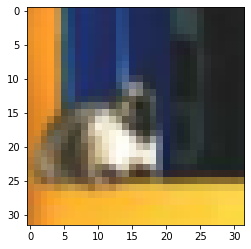

Image 7 : Class is  b'cat'


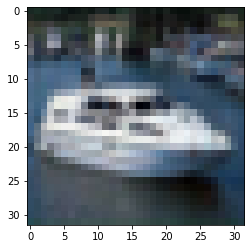

Image 8 : Class is  b'ship'


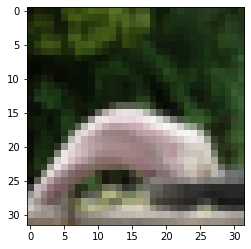

Image 9 : Class is  b'bird'


In [87]:
# Display a few images from the batch
for i in range (0,10):
    visualise(data, i)
    print("Image", i,": Class is ", names[labels[i]])

In [88]:
data

array([[255, 252, 253, ..., 173, 231, 248],
       [127, 126, 127, ..., 102, 108, 112],
       [116,  64,  19, ...,   7,   6,   5],
       ...,
       [ 35,  40,  42, ...,  77,  66,  50],
       [189, 186, 185, ..., 169, 171, 171],
       [229, 236, 234, ..., 173, 162, 161]], dtype=uint8)

In [89]:
image_data = np.array(data)

In [98]:
pd.unique(labels)

array([1, 8, 5, 7, 4, 3, 2, 0, 9, 6])

## Labels of CIFAR Dataset

In [91]:
for n in names:
    print(n.decode("utf-8"),'-',names.index(n))

airplane - 0
automobile - 1
bird - 2
cat - 3
deer - 4
dog - 5
frog - 6
horse - 7
ship - 8
truck - 9


## Predict between any two classes:
0 = airplane

2 = bird

In [92]:
index=[]
index_counter=0
for label in labels:
    if label==0 or label==2:
        index.append(index_counter)
    index_counter = index_counter+1

In [102]:
selected_labels = []
for i in index:
  selected_labels.append(labels[i])
pd.unique(selected_labels)

array([2, 0])

In [100]:
data_train=image_data[index]

In [101]:
data_train

array([[ 17,  25,  22, ..., 126, 122, 116],
       [ 75, 104,  84, ..., 118, 115, 109],
       [238, 248, 253, ..., 149, 155, 153],
       ...,
       [155, 154, 154, ...,  71,  72,  72],
       [156, 155, 156, ..., 163, 162, 162],
       [145, 151, 156, ...,  56,  53,  54]], dtype=uint8)

In [104]:
target=[]
for i in selected_labels:
    if i==0:
        target.append(0)
    else:
        target.append(1)

In [105]:
pd.unique(target)

array([1, 0])

In [106]:
x_train,x_test,y_train,y_test=train_test_split(data_train,target,test_size=0.20)

In [107]:
def modal_part_four(x,y,max_iter,alpha,threshold=10**-6):

    ## take a random wight at the start, it can be any wight because through the iteration we will be going to update it 
    weight=np.random.normal(0,0.01,x.shape[1])
    ## it is the bias it will also any number but we take a uniform array of biases throught out, we will be adding out bias to weights
    bias=np.random.uniform(0,1)

    ## we will loop till the value of maximum teration or if the convergence comes before max iteration we break the loop
    while(max_iter!=0):
        index = np.random.randint(x.shape[0])
        x_index = x[index]
        y_index = y[index]

        ## we valculate the value of y_hat and with the value of y_hat we find out cost
        y_hat=sigmoid(np.dot(weight,x_index)+bias)
        ## cost is calculated on the bases of the y_hat
        cost_old=cost(y_hat,y_index)

        ## we update out wights 
        weight=weight-alpha*get_weight(y_hat,y_index,x_index)
        ## update bias
        bias=bias-alpha*get_bias(y_hat,y_index)

        ## now with the updated bias and wights we calcualte our new cost
        ## then new cost is more relevent as we have upadated our weights
        y_hat=sigmoid(np.dot(weight,x_index)+bias)
        cost_new=cost(y_hat,y_index)

        ## we take the absolute value and break the loop then the cost difference is less then the threshold. 
        ## more low the threshold more accurate the values are
        if abs(cost_old-cost_new) < threshold:
            break
        
        ## we dicrease the iteration to reach end of the loop
        max_iter = max_iter - 1

    return weight,bias

In [108]:
## here we set the cut off threshold and with the wight and bias we calculate our target value
def predict(x,w,b):
    y_return=[]
    cut_off=0
    y_predict=np.dot(x,w)+b
    for y in y_predict:
        if y>cut_off:
            y_return.append(1)
        else:
            y_return.append(0)
    return y_return

In [109]:
## here actual and predicted y values are compared and we find the accuracy
def accuracy(predict_y,actual_y):
    y_count = 0
    for i in range(len(actual_y)):
        if predict_y[i]==actual_y[i]:
            y_count=y_count+1
    return y_count/len(actual_y)

In [115]:
w_1,b_1= modal_part_four(x_train,y_train,max_iter=100000,alpha=0.001,threshold=10**-6)
y_pred=predict(x_test,w_1,b_1)
accuracy(y_pred,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


0.7741116751269036